In [3]:
import os
import random
# XML 다루는 라이브러리
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [28]:
# 학습 및 검증용 화상 데이터, 어노테이션 데이터 파일 경로 리스트 작성
def make_datapath_list(rootpath):
    img_file_path = os.path.join(rootpath, 'JPEGImages', '%s.jpg') # %연산 시 3번째 arg형태로 파일명이 됨
    annotation_path = os.path.join(rootpath, 'Annotations', '%s.xml')

    train_file_id = os.path.join(rootpath + 'ImageSets/Main/train.txt')
    val_file_id = os.path.join(rootpath + 'ImageSets/Main/val.txt')

    train_img_list = []
    train_annotation_list = []

    for line in open(train_file_id): # txt파일을 한줄씩 읽어옴
        file_id = line.strip() 
        img_file_name = (img_file_path % file_id)  # 画像のパス
        anno_file_name = (annotation_path % file_id)  # アノテーションのパス
        train_img_list.append(img_file_name)  # リストに追加
        train_annotation_list.append(anno_file_name)  # リストに追加

    val_img_list = []
    val_annotation_list = []

    for line in open(val_file_id): # txt파일을 한줄씩 읽어옴
        file_id = line.strip()  
        img_file_name = (img_file_path % file_id)  
        anno_file_name = (annotation_path % file_id)  
        val_img_list.append(img_file_name)  # 
        val_annotation_list.append(anno_file_name)  #

    return train_img_list, train_annotation_list, val_img_list, val_annotation_list

In [29]:
rootpath = './data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [34]:
class Anno_xml2list(object): 
    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        # 물체의 어노테이션 데이터를 저장한 리스트. 이미지에 존재하는 물체 수만큼 len을 가짐.
        ret = [] #ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]

        # xml파일로드
        xml = ET.parse(xml_path).getroot()

        # xml에서 <object>의 수만큼 반복
        for obj in xml.iter('object'):

            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 바운딩 박스 어노테이션 정보를 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 물체이름
            bbox = obj.find('bndbox')  # 바운딩박스 정보

            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC데이터셋은 원점이 (1,1)이므로 빼줌
                cur_pixel = int(bbox.find(pt).text) - 1

                # 정규화
                if pt == 'xmin' or pt == 'xmax':  # x의 경우 width로 나눔
                    cur_pixel /= width
                else:  # y는 높이인 height로 나눔
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 class명에 해당하는 index번호 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            ret += [bndbox]

        return np.array(ret) #[[xmin, ymin, xmax, ymax, label_ind], ... ]

In [39]:
val_anno_list[1], val_img_list[1]

('./data/VOCdevkit/VOC2012/Annotations/2008_000003.xml',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg')

In [37]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [높이][폭][RGB]
height, width, channels = img.shape  # 이미지 크기

# 어노테이션 리스트로 표시
transform_anno(val_anno_list[ind], width, height) # 해당 파일엔 object가 2개 있음

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [41]:
from data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

In [46]:
# 이미지와 bbox전처리 실시
class DataTransform():
    def __init__(self, input_size, color_mean): # color_mean : (BGR) - cv2는 BGR순서
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # 
                ToAbsoluteCoords(),  # 
                PhotometricDistort(),  # 
                ToPercentCoords(),  # 
                Resize(input_size),  # 
                SubtractMeans(color_mean)  # 
            ]),
            'val': Compose([
                ConvertFromInts(),  # 
                Resize(input_size),  # 
                SubtractMeans(color_mean)  
            ])
        }

    def __call__(self, img, phase, boxes, labels): # phase : 'train' or 'val'

        return self.data_transform[phase](img, boxes, labels)

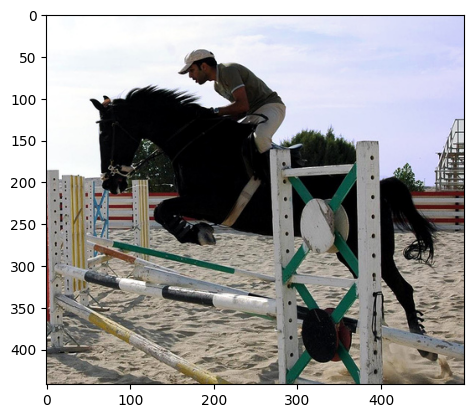

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


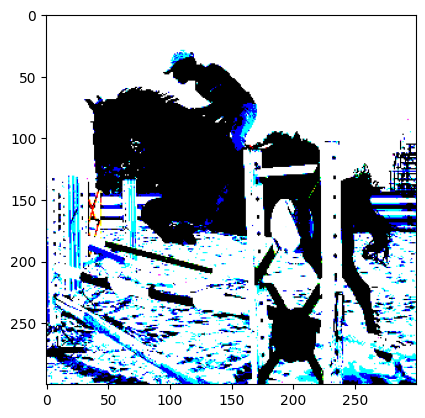

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


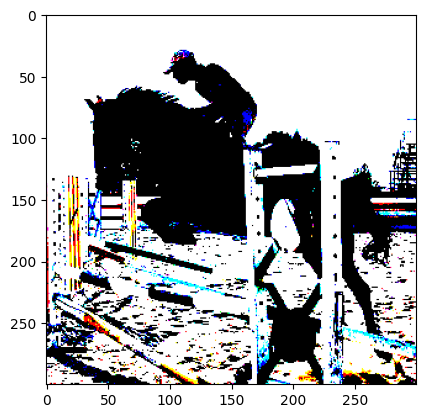

In [50]:
# 이미지 불러오기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [높이][폭][BGR]
height, width, channels = img.shape  # 이미지 shape

# 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 원래 이미지 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# data 변형
color_mean = (104, 117, 123)  # (BGR) 색상의 평균값
input_size = 300  # 이미지input 사이즈를 300x300 으로
transform_data = DataTransform(input_size, color_mean)

# 5. train 변형
phase = "train"
img_transformed, boxes, labels = transform_data(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val 변형
phase = "val"
img_transformed, boxes, labels = transform_data(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [61]:
boxes

array([[0.104     , 0.19457014, 0.94      , 0.9479638 ],
       [0.314     , 0.09728507, 0.576     , 0.37556561]])

In [67]:
class VOCDataset(data.Dataset):
    """
    torch.utils.data.Dataset 상속받음
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list # 이미지 경로 저장된 리스트
        self.anno_list = anno_list # 어노테이션 경로 저장된 리스트
        self.phase = phase  # train or val 지정
        self.transform = transform  # 이미지 변경
        self.transform_anno = transform_anno  # xml 정보 리스트 변경

    def __len__(self):
        return len(self.img_list) # 이미지 리스트 개수 반환

    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][색][BGR]
        height, width, channels = img.shape  # [높이][색][BGR]

        anno_file_path = self.anno_list[index] 
        anno_list = self.transform_anno(anno_file_path, width, height) # 해당 높이와 너비로 anno_list 만들기

        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4]) # BGR -> RGB, (높이, 폭, 채널) -> (채널, 높이, 폭)
 
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
 
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1))) # bbox와 라벨을 한 세트로

        return img, gt, height, width

In [90]:
color_mean = (104, 117, 123)  # (BGR) 평균값
input_size = 300  # 이미지 input size

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# 데이터 출력 예(image, bbox+label)
a,b = val_dataset[11] #== val_dataset.__getitem__(1)

In [101]:
a#.size()

tensor([[[ -9.2967,  -9.7533,  -9.5433,  ..., -16.3389, -18.3433, -21.5944],
         [ -3.8300,  -5.4100,  -6.3233,  ..., -37.1833, -38.3300, -40.6267],
         [ -8.0444,  -9.6333, -10.5556,  ..., -40.1278, -40.9167, -42.5833],
         ...,
         [-80.0333, -69.7000, -75.4944,  ..., -31.3889, -39.7667, -50.3889],
         [-79.6933, -72.9300, -75.3600,  ..., -40.1967, -37.8500, -37.2600],
         [-84.5889, -84.8900, -80.8400,  ..., -51.8989, -36.8767, -38.5844]],

        [[-10.1733,  -7.7533,  -6.7944,  ...,  -8.6722,  -9.3433, -12.5944],
         [ -3.4600,  -3.0400,  -2.6200,  ..., -29.1467, -28.9600, -31.2567],
         [ -6.4278,  -6.0167,  -5.6056,  ..., -31.4611, -30.9167, -32.5833],
         ...,
         [-74.0333, -63.7000, -69.4944,  ...,   0.3056, -12.5333, -22.1556],
         [-73.6933, -66.9300, -69.3600,  ...,  -9.5300, -11.8500, -10.2600],
         [-78.5889, -78.8900, -74.8400,  ..., -20.9400,  -9.1233,  -9.8311]],

        [[ -5.6667,  -4.1233,  -3.2467,  ...

In [91]:
b

array([[ 0.33      ,  0.46524064,  0.848     ,  0.9171123 , 10.        ],
       [ 0.486     ,  0.4144385 ,  0.63      ,  0.76470588,  8.        ],
       [ 0.654     ,  0.43048128,  0.774     ,  0.51604278,  8.        ],
       [ 0.708     ,  0.47860963,  0.878     ,  0.87433155,  8.        ],
       [ 0.576     ,  0.52406417,  0.744     ,  0.89572193,  8.        ],
       [ 0.326     ,  0.51871658,  0.526     ,  0.91176471,  8.        ],
       [ 0.298     ,  0.42780749,  0.37      ,  0.7513369 ,  8.        ]])

In [92]:
# 각 이미지마다 어노테이션 및 이미지 내 객체의 수가 다 다르기 때문에 필요한 함수(dataloader collate_fn에서 사용됨)
# 예를 들어 한 이미지의 객체가 3개면 (3,5), 2개면 (2,5) 등
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # 이미지
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] 어노테이션 정보

    imgs = torch.stack(imgs, dim=0)

    return imgs, targets

In [114]:
batch_size = 4

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


batch_iterator = iter(dataloaders_dict["val"]) 
images, targets = next(batch_iterator)
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets)

torch.Size([4, 3, 300, 300])
4
[tensor([[ 0.0660,  0.0267,  0.8940,  0.7787, 19.0000]]), tensor([[ 0.0900,  0.0300,  0.9980,  0.9970, 18.0000],
        [ 0.1220,  0.5676,  0.1640,  0.7267, 14.0000]]), tensor([[0.0000, 0.6107, 0.8540, 0.7787, 3.0000]]), tensor([[0.4320, 0.4267, 0.5860, 0.5867, 9.0000],
        [0.9280, 0.4427, 0.9980, 0.5787, 9.0000]])]
